<DIV ALIGN=CENTER>

# Introduction to Regression
## Professor Robert J. Brunner
  
</DIV>  
-----
-----

## Introduction

In _INFO 490: Foundations of Data Science_ (and earlier versions of the
pre-requisite courses, we have encouraged students to use Python (and in
some cases the Unix command line) to summarize and visually explore a
data set. In some of these visualizations, the data demonstrated
definite trends between one or more variables. These visual
representations are useful in understanding data, but we often want to
model the data in order (1) to extract a physical understanding of the
trends and (b) to predict future responses given new data. For example,
we might want to predict the actual arrival time for flights based on
previous flight data. Alternatively we might want to investigate the
physical reasons for specific flights or airports that show excessive
departure or arrival delays.

In this notebook, we introduce the concept of regression. We can use
regression to _fit a model to data_. The resulting model can be explored
in greater detail to understand why the data follow the model, or the
model can be used to make predictions on future or unseen data. To
compute the model, we will first use the numpy library, before moving to
the StatsModel and scikit learn libraries.

-----

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", font_scale=2.0)

-----
### Data

Before exploring different techniques for modeling a data set, we first
need data to analyze. Rather than jumping straight into a large, and
potentially messy, data set like the flight data, we will start by
generating fake data. Now we could have a hidden driving function, so
that any of the following analyses are unbiased. For simplicity, however,
we simply make random data that is nearly linear. Once our function is
defined, we create a sample of data and plot the results.

Note that since we randomly generate our data, every time this Notebook
is run, we will get different results. Take advantage of this feature to
compare the different approaches as the underlying data change.

-----

In [2]:
# We define a simple function to fit.

np.random.seed(0)

def theModel(xmin=0, xmax = 1, num=20):
    
    sigma = 0.1

    x = np.linspace(xmin, xmax, num)
    y = 0.25 + 0.5 * x - sigma * np.random.randn(len(x)) - sigma * x **2

    return(x, y)

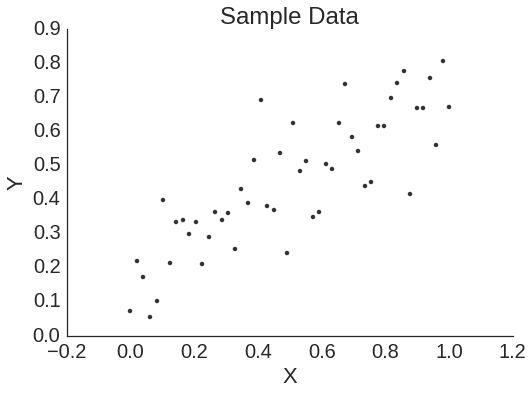

In [3]:
x, y = theModel(num = 50)
ax = sns.regplot(x, y, fit_reg=False, color='black', label="Data")

ax.set(xlabel='X', ylabel='Y', title='Sample Data')
sns.despine(offset=0, trim=True)

----

### Polynomial Fitting

A simple first step is to see how different polynomial functions fit our
data. The numpy library includes a [polyfit][npf] function that will fit
a polynomial of a a given order to a data set. The best fit is
determined by minimizing the squared error (between known and fitted
values). With this function, we can look at how different polynomials
model our data.

-----
[npf]: http://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html



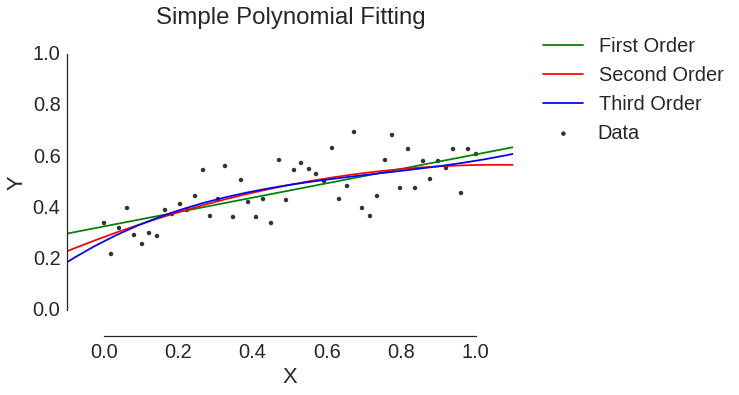

In [4]:
x, y = theModel(num = 50)
ax = sns.regplot(x, y, fit_reg=False, color='black', label="Data")

xf = np.linspace(-0.20,1.2,25)

pf1 = np.poly1d(np.polyfit(x, y, 1))
plt.plot(xf, pf1(xf), c='g', label="First Order")

pf2 = np.poly1d(np.polyfit(x, y, 2))
plt.plot(xf, pf2(xf), c='r', label="Second Order")

pf3 = np.poly1d(np.polyfit(x, y, 3))
plt.plot(xf, pf3(xf), c='b', label="Third Order")

#pfn = np.poly1d(np.polyfit(x, y, 10))
#plt.plot(xf, pfn(xf), c='b', label="High Order")

ax.set(title='Simple Polynomial Fitting',
       xlabel='X', xlim=(-0.1, 1.1),
       ylabel='Y', ylim=(-0.1, 1.1))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #loc=4)
sns.despine(offset=0, trim=True)

-----

This previous plot is important for a multitude of reasons. Notice how
each polynomial fits the data quite well over the range of the
independent variable (i.e., `x`). This range is often described as the
_support_, since these data values are used to fit or train the model.
Outside this range, the functions have no support, and are thus
unconstrained. This is shown in the figure by the (for some data)
rapidly diverging models beyond the supporting data. 

Second, as the polynomial order increases, we can eventually reach a
point of _overfitting_ the data. This can be easily seen by uncommenting
the two lines that fit a tenth order polynomial (you can change this
order and see the effect). In this case, the polynomial begins to
capture the fine details in the data distribution, which can often simply
be the result of noise in measurement processes. Overfitting is a major
concern when determining model fits, and overcoming this issue leads us
into more formal model fitting methods.

-----

## Linear Regression

The polynomial fitting demonstrated earlier in this notebook provides a
nice method for quickly generating a model approximation to a data set.
However, it uses a fixed fitting criterion and thus is less flexible
than we might like. The formal method of determining a best fitting
model is known as regression, and the most common implementation is
known as [**Linear Regression**][lrw]. linear regression models can be
quantified by using a least squares approach, or they can be determined
by using an alternative fit criteria such as least absolute deviations
or penalty or loss function. An important concept with linear regression
is that the _linear_ term does not refer to the functional order of the
input features, but to the parameters that multiply these features.
Thus, a linear regression can involve polynomials or other functions of
the features, although we will not discuss this in the current Notebook.

### Statsmodels

In the next few code blocks, we employ the statsmodel library to perform
ordinary least squares on our generated data set. [Statsmodels][sm] is a
Python library that implements a number of statistical methodology,
often in concert with Pandas. We will first construct a Pandas DataFrame
from our generated data, before adding in a constant column (or feature)
so that our fit will have two parameters: an intercept and a slope. We
then use the built-in fitting in Seaborn to show the expected result
(note that Seaborn also automatically displays the confidence intervals,
which are not discussed in this Notebook).

-----
[lrw]: https://en.wikipedia.org/wiki/Linear_regression
[sm]: http://statsmodels.sourceforge.net

In [5]:
import statsmodels.api as sm

df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.000000,0.339547
1,0.020408,0.221472
2,0.040816,0.321322
3,0.061224,0.398301
4,0.081633,0.292968


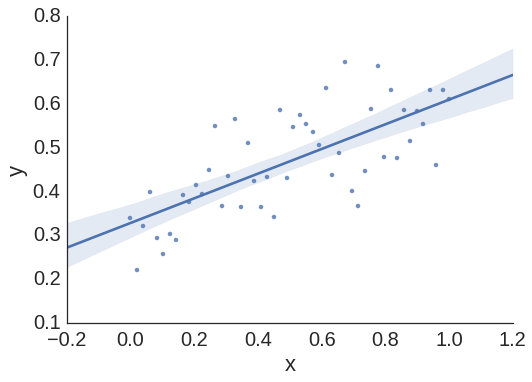

In [6]:
ax = sns.regplot('x', 'y', df, fit_reg=True)

sns.despine(offset=0, trim=True)

-----

Now that we have an appropriate DataFrame, we can easily employ the
formulaic interface to obtain an ordinary least squares fit to the data
of interest. The formulaic interface is borrowed from `R`, and simply
relates the result to the features. In our case, we map the `y` label to
the x features in the first example, this will include the constant term
in the calculation. In the second example, we remove the constant term to
obtain the best fit line with zero intercept (simply for comparison).
After we calculate these two fits, we plot the data and fits for a
visual analysis of the results.

-----

In [7]:
import statsmodels.formula.api as smf

# Implement simple regression: Result ~ Input

# First we fit slope and intercept
result = smf.ols(formula='y ~ x', data=df).fit()

# Fit a no intercept line
result_noi = smf.ols(formula='y ~ x - 1', data=df).fit()


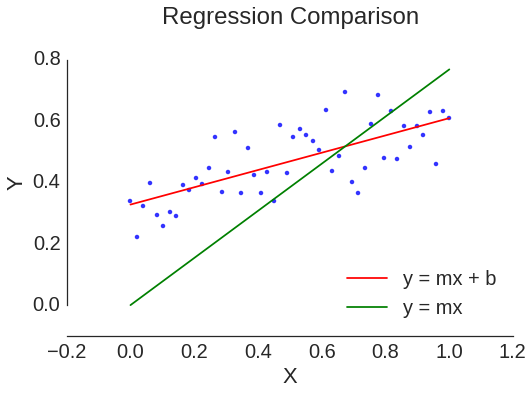

In [8]:
ax = sns.regplot('x', 'y', df, fit_reg=False, color='blue')

# We pick 100 hundred points equally spaced from the min to the max
xfpd = pd.DataFrame({'xfpd': np.linspace(0, 1, 50)})

yfi = result.predict(xfpd)
yfi_noi = result_noi.predict(xfpd)

plt.plot(xfpd['xfpd'], yfi, color='red', label='y = mx + b')
plt.plot(xfpd['xfpd'], yfi_noi, color='green', label='y = mx')

ax.set(xlabel='X', ylabel='Y', title='Regression Comparison')
ax.legend(loc=4)
sns.despine(offset=0, trim=True)

-----

### Scikit Learn

The most commonly used statistical and machine learning library in
Python is the [scikit learn][skl] library. This library includes a
number of different model fitting techniques (in addition to general
regression and classification algorithms) that can be easily applied to
a data set. While we will focus below on the linear regression
estimator, the scikit learn library includes a number of other
estimators that can be used to improve model fits while minimizing the
risk of overfitting, including

- Ridge Regression
- Lasso
- Elastic Net
- Orthogonal Matching Pursuit
- Bayesian regression
- Stochastic Gradient Descent
- Robust regression

To learn about these more advanced techniques, see the relevant library
documentation page. We also will cove some of these concepts in more
detail in the second week of this course.

In the following code cells, we use the `LinearRegression` estimator
within the scikit learn library to fit our sample data, plot the
results, and finally display the fit coefficients.

-----
[skl]: http://scikit-learn.org/stable/index.html

y = 0.33 + 0.28 x


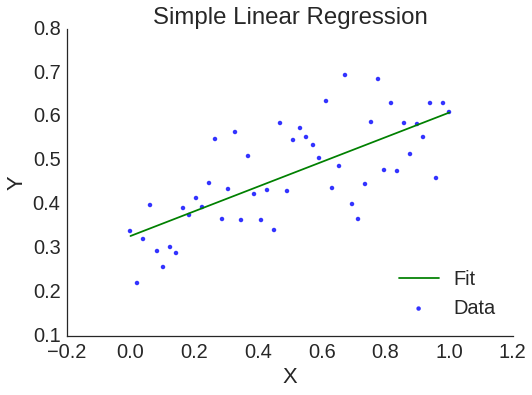

In [9]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x[:, np.newaxis], y)

# Plot the data and the model prediction
xf = np.linspace(0, 1, 25)
yf = model.predict(xf[:, np.newaxis])

ax = sns.regplot(x, y, fit_reg=False, color='blue', label="Data")

ax.set(xlabel='X', ylabel='Y', title='Simple Linear Regression')
plt.plot(xf, yf, c='g', label="Fit")
ax.legend(loc=4)
sns.despine(offset=0, trim=True)

print("y = {0:4.2f} + {1:4.2f} x".format(model.intercept_, model.coef_[0]))

-----

#### Cross-Validation

To this point, we have used all of our data to fit a model, and generate
new data samples to test the model fit. Often, we only have  single data
set, yet we still want to quantify the quality of a particular fit. In
this case, we can employ the scikit learn libraries cross-validation
implementation, where we split our data set into a training sample and a
testing sample. The training data are used to construct the model, and
the testing data quantify the quality of the fit. This is demonstrated
in the following code cells, where we split our data `60:40` into
training and testing data, before computing a linear regression and
visually analyzing the result.

-----

In [10]:
#Now plot the data
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6)

y = 0.33 + 0.24 x
MSE = 0.009


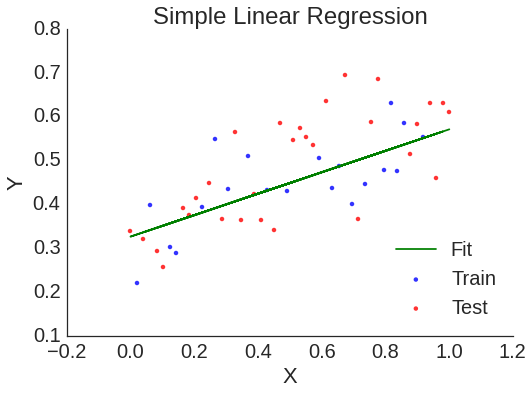

In [11]:
model = LinearRegression()
model.fit(x_train[:, np.newaxis], y_train)

# Plot the data and the model prediction
#xf = np.linspace(0, 1, 25)
yf = model.predict(x_test[:, np.newaxis])

ax = sns.regplot(x_train, y_train, fit_reg=False, color='blue', label="Train")
ax = sns.regplot(x_test, y_test, fit_reg=False, color='red', label="Test")


ax.set(xlabel='X', ylabel='Y', title='Simple Linear Regression')
plt.plot(x_test, yf, c='g', label="Fit")
ax.legend(loc=4)
sns.despine(offset=0, trim=True)


print("y = {0:4.2f} + {1:4.2f} x".format(model.intercept_, model.coef_[0]))
print("MSE = {0:5.3f}".format(np.mean((yf-y_test)**2)))